In [ ]:
# reference: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

In [98]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout 
from torch.optim import Adam, SGD
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [99]:
# loading dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

train.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [100]:
# loading training images
train_img = []
for img_name in tqdm(train['id']):
    # defining the image path
    image_path = 'train/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = train['label'].values
train_x.shape

100%|██████████| 60000/60000 [00:36<00:00, 1624.63it/s]


(60000, 28, 28)

(<Axes: title={'center': 'Sneaker'}>,
 Text(0.5, 1.0, 'Sneaker'))

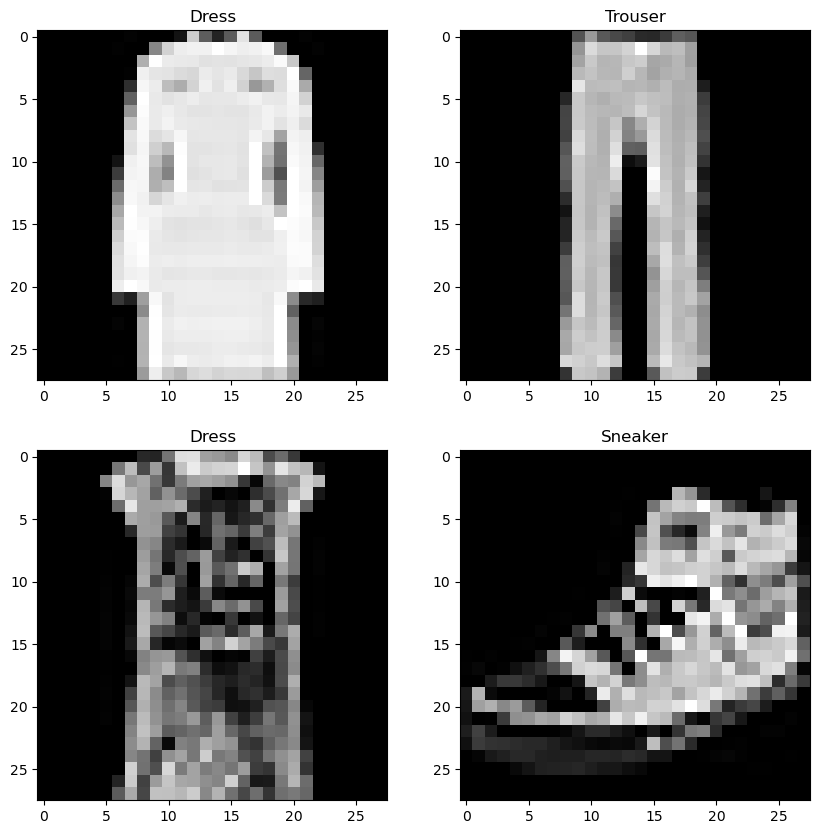

In [101]:
# visualizing images
class_desc = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', \
              6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

i = 500
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray'), plt.title(class_desc[train_y[i]])
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray'), plt.title(class_desc[train_y[i+25]])
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray'), plt.title(class_desc[train_y[i+50]])
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray'), plt.title(class_desc[train_y[i+75]])

In [102]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [103]:
# converting training images into torch format
train_x = train_x.reshape(54000, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

# converting validation images into torch format
val_x = val_x.reshape(6000, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape


(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

In [97]:
def create_batches(images, labels, batch_size):
    # Shuffle the indices
    indices = torch.randperm(len(images))
    images, labels = images[indices], labels[indices]
    
    # Yield batches
    for start in range(0, len(images), batch_size):
        end = start + batch_size
        yield images[start:end], labels[start:end]

In [75]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.25),   # Dropout with 25% probability
        )

        self.linear_layers = Sequential(
            Linear(64 * 7 * 7, 128),  # An intermediate dense layer
            ReLU(inplace=True),
            Dropout(0.25),  # Higher dropout before the final layer
            Linear(128, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [92]:
from torchinfo import summary

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = CrossEntropyLoss()
# defining batch
batch_size = 64
# checking if GPU is available
if torch.cuda.is_available():
    model = model.to('cuda')
    criterion = criterion.to('cuda')

print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')
summary(model, input_size=(1, 1, 28, 28))

421.834 K parameters


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 7, 7]             --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           64
│    └─ReLU: 2-3                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 64, 14, 14]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 14, 14]           128
│    └─ReLU: 2-7                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-8                    [1, 64, 7, 7]             --
│    └─Dropout: 2-9                      [1, 64, 7, 7]             --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-10                      [1, 128]                  401,536
│   

In [94]:
@torch.no_grad()
def estimate_loss(is_training=True):
    if not is_training:
        model.eval()
    
    output_val = model(val_x.to('cuda'))

    # computing the training and validation loss
    loss_val = criterion(output_val, val_y.to('cuda'))
    val_losses.append(loss_val)

    if is_training:
        model.train()
    return loss_val.item()

@torch.no_grad()
def calc_accu(is_training=True):
    if not is_training:
        model.eval()
        
    output_val = model(val_x.to('cuda'))

    softmax = torch.exp(output_val).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    val_accu = accuracy_score(val_y, predictions)

    if is_training:
        model.train()
    
    return val_accu.item()
    
def print_gradients(model):
    for name, parameter in model.named_parameters():
        if parameter.grad is not None:
            print(f"{name} gradient: {parameter.grad.norm().item()}")
        else:
            print(f"{name} has no gradient")

def init_kaiming(model):
    for m in model.modules():
        if isinstance(m, (Conv2d, Linear)):
            torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

def train(epoch):
    print(f'epoch:{epoch}---------')
    model.train()

    iteration = 0
    for images_batch, labels_batch in create_batches(train_x, train_y, batch_size):
        # clearing the Gradients of the model parameters
        optimizer.zero_grad()
        
        # prediction for training and validation set
        output_train = model(images_batch.to('cuda'))
    
        # computing the training and validation loss
        loss_train = criterion(output_train, labels_batch.to('cuda'))
        train_losses.append(loss_train.item())
        
        # computing the updated weights of all the model parameters
        loss_train.backward()
    
        optimizer.step()

        iteration += 1
        if iteration%100 == 0:
            print(f'Iteration : {iteration+1}, train loss:{loss_train.item():.4f}, val loss:{loss_val:.4f}, val accu: {accu_val:.4f}')

In [96]:
#init_kaiming(model)
# defining the number of epochs
n_epochs = 10
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

epoch:0---------
Iteration : 101, train loss:2.3178, val loss:2.3262, val accu: 0.1075
Iteration : 201, train loss:2.3134, val loss:2.3135, val accu: 0.1073
Iteration : 301, train loss:2.3012, val loss:2.3077, val accu: 0.1073
Iteration : 401, train loss:2.3261, val loss:2.3053, val accu: 0.1073
Iteration : 501, train loss:2.3097, val loss:2.3041, val accu: 0.1073
Iteration : 601, train loss:2.3009, val loss:2.3037, val accu: 0.1073
Iteration : 701, train loss:2.2996, val loss:2.3035, val accu: 0.0960
Iteration : 801, train loss:2.3022, val loss:2.3032, val accu: 0.0960
epoch:1---------
Iteration : 101, train loss:2.3010, val loss:2.3031, val accu: 0.0968
Iteration : 201, train loss:2.3037, val loss:2.3031, val accu: 0.0968
Iteration : 301, train loss:2.3006, val loss:2.3028, val accu: 0.0960
Iteration : 401, train loss:2.3028, val loss:2.3027, val accu: 0.0960
Iteration : 501, train loss:2.3016, val loss:2.3027, val accu: 0.0960
Iteration : 601, train loss:2.3041, val loss:2.3026, val

In [ ]:
import torch
import sys

def print_gpu_memory_usage():
    total_memory = 0
    print("GPU Memory Usage:")
    for var_name in globals():
        var = globals()[var_name]
        if torch.is_tensor(var) and var.is_cuda:
            # Calculate memory usage in Megabytes
            memory_usage = var.element_size() * var.nelement() / (1024**2)  # Convert to MB
            total_memory += memory_usage
            print(f"{var_name}: shape = {var.size()}, dtype = {var.dtype}, memory = {memory_usage:.2f} MB")
    print(f"Total GPU memory used: {total_memory:.2f} MB")

print_gpu_memory_usage()

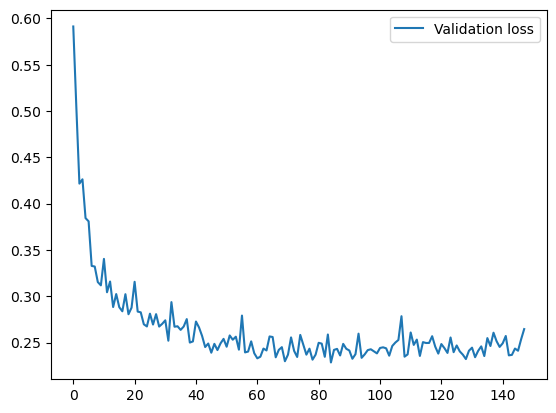

In [71]:
# plotting the training and validation loss
train_losses_cpu = [loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() for loss in val_losses]
#plt.plot(train_losses_cpu, label='Training loss')
plt.plot(val_losses_cpu, label='Validation loss')
plt.legend()
plt.show()

In [80]:
# prediction for training set
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y.cpu(), predictions)

0.8171851851851852

In [24]:
accu = calc_accu(True)
accu

[0.8964074074074074, 0.8983333333333333]

In [27]:
loss = estimate_loss(True)
loss

[0.2897319793701172, 0.30211129784584045]

In [75]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [43]:
# loading test images
test_img = []
for img_name in tqdm(test['id']):
    # defining the image path
    image_path = 'test/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)

# converting the list to numpy array
test_x = np.array(test_img)
test_x.shape

100%|██████████| 10000/10000 [00:05<00:00, 1690.40it/s]


(10000, 28, 28)

In [44]:
# converting training images into torch format
test_x = test_x.reshape(10000, 1, 28, 28)
test_x  = torch.from_numpy(test_x)
test_x.shape

torch.Size([10000, 1, 28, 28])

In [45]:
# generating predictions for test set
with torch.no_grad():
    output = model(test_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

In [46]:
# replacing the label with prediction
sample_submission['label'] = predictions
sample_submission.head()

,id,label
0,60001,9
1,60002,2
2,60003,1
3,60004,1
4,60005,6


9.146 K parameters


In [53]:
torch.save(model.state_dict(), 'fashion_mnist_cnn_model_weights_2023_04_23.pth')